# 线性回归

In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 构造数据集
根据真实的数据来构造一些可以回归的数据组，对于这些数据组而言我们需要添加一些噪音来推进后续的分析

In [12]:
def synthetic_data(w,b,num_examples):
    """ 生成 y = Xw + b + 噪声。"""
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape) # 均值为0，方差为1
    # print(X)
    # print(y)
    return X, y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
print(features,labels)
print(len(features))

tensor([[-0.6975,  2.3777],
        [-0.0821,  0.7220],
        [-1.0273,  0.3863],
        ...,
        [-2.4162, -0.5614],
        [-0.4516,  0.2292],
        [ 1.2217, -0.0858]]) tensor([[ -5.2810],
        [  1.5735],
        [  0.8313],
        [  4.8134],
        [  4.5041],
        [  6.7622],
        [  1.9661],
        [  7.6918],
        [  9.0292],
        [  0.6415],
        [  6.1848],
        [ 12.2327],
        [  4.5728],
        [  0.4654],
        [  3.6564],
        [  2.1901],
        [ -3.8273],
        [  2.4019],
        [  1.5975],
        [  7.7612],
        [ -2.1627],
        [  6.5556],
        [  7.5566],
        [ -1.3247],
        [ -5.9198],
        [ -0.2969],
        [ -5.0429],
        [  6.7046],
        [  1.3415],
        [  1.0707],
        [  5.3007],
        [  9.7238],
        [  3.2273],
        [  8.1916],
        [  1.0125],
        [  4.6329],
        [ 13.9055],
        [  2.1932],
        [  7.8503],
        [  3.3714],
        [  4.1344]

`features`中的每一行都包涵一个二维数据样本，`labels`中的每一行都含有一个一维标签值。

In [6]:
print('features',features[0],'\nlabel:',labels[0])

features tensor([-0.6902,  0.2736]) 
label: tensor([1.8730])


使用`d2l`画图，用特征的第一列。

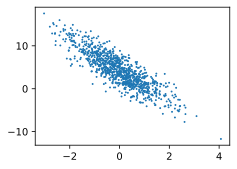

In [24]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)

定义一个`data_iter`函数，函数接受小批量的数据、特征矩阵和标签向量作为输入，生成大小为`batch_size`小批量。这里的`barch_size`数据批量被称为`超参数`。

In [14]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 随机读取样本 这里只打乱了数据的下标顺序。
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size): # 跳过batchsize大小
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)]) # 随机抽取10个样本参与计算
        yield features[batch_indices], labels[batch_indices] # 返回迭代器 一个batch中
batch_size = 10 # 超参数可以修改

for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 0.3401,  1.1596],
        [-1.1535, -2.0409],
        [-1.0266,  0.8040],
        [-0.5639, -0.2544],
        [ 1.1431, -0.7887],
        [ 2.1153,  0.3679],
        [-0.1317, -1.8423],
        [ 0.1756,  0.4212],
        [-1.9813,  0.7085],
        [-1.4165, -1.1602]]) 
 tensor([[ 0.9250],
        [ 8.8308],
        [-0.5968],
        [ 3.9301],
        [ 9.1683],
        [ 7.1900],
        [10.1843],
        [ 3.1185],
        [-2.1627],
        [ 5.2823]])


## 定义模型

In [31]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [32]:
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w) + b

## 定义损失函数

In [33]:
def squared_loss(y_hat,y):
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## 定义优化算法

In [34]:
def sgd(params,lr,batch_size): # 参数和学习率
    """ 小批量随机梯度下降。"""
    with torch.no_grad(): # 更新的时候不参与梯度运算
        for param in params:
            param -= lr * param.grad / batch_size # 求均值在优化的过程中
            param.grad.zero_() # 手动梯度清零

## 训练过程

In [35]:
lr = 10 # 定义学习率 也是一个可以调整的超参数
num_epochs = 3 # 多跑几次 也是一个可调的超参数
net = linreg # 神经网络模型
loss = squared_loss

for epoch in range(num_epochs): # 对数据扫描
    for X,y in data_iter(batch_size,features,labels): # 每次拿出一个小批量
        l = loss(net(X,w,b),y) # X 和 y 的小批量损失
        l.sum().backward() # l的形状是(`batch_size`,1)，而不是一个标量。
        sgd([w,b],lr,batch_size) # 更新参数
    with torch.no_grad():
        train_1 = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1}, loss {float(train_1.mean()):f}')

epoch 1, loss nan
epoch 2, loss nan
epoch 3, loss nan


比较真实参数和通过训练学到的参数来评估训练是否成功。

In [22]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-0.0006, -0.0003], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0001], grad_fn=<RsubBackward1>)


# 简洁实现
## 使用deep learning 框架

In [53]:
import numpy as np
from torch.utils import data

In [54]:
features,labels = d2l.synthetic_data(true_w,true_b,1000) # 人工数据合成函数 根据真实参数生成对应数据

## 调用框架中现有的API来读取数据

In [55]:
def load_array(data_arrays,batch_size,is_train=True):
    '''构造一个PyTorch数据迭代器。'''
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train) # 实际上是随机从里面挑batch_size个数据
data_iter = load_array((features,labels),batch_size)

next(iter(data_iter))

[tensor([[ 2.5092, -0.8525],
         [ 0.8983,  0.4204],
         [-1.0441, -1.1177],
         [-1.2752, -0.0760],
         [ 0.5316, -1.9622],
         [ 0.9415,  0.1715],
         [-1.7138, -1.4417],
         [-0.9550, -1.4375],
         [-1.2736, -0.5998],
         [-0.3606, -0.2946]]),
 tensor([[12.1163],
         [ 4.5827],
         [ 5.9406],
         [ 1.8997],
         [11.9418],
         [ 5.5081],
         [ 5.6810],
         [ 7.1683],
         [ 3.6789],
         [ 4.4894]])]

## 使用框架预定义好的层

In [56]:
from torch import nn

net = nn.Sequential(nn.Linear(2,1))

## 初始化模型的参数

In [57]:
net[0].weight.data.normal_(0,0.01) # 将该线性层的权重参数初始化为均值为0、标准差为0.01的正态分布随机数(w)
net[0].bias.data.fill_(0) # 将偏置参数初始化为0(b)

tensor([0.])

## 计算均方误差
使用`MSELoss`类，称为平方范数。

In [58]:
loss = nn.MSELoss()

In [59]:
trainer = torch.optim.SGD(net.parameters(),lr=0.03) # 实例化SGD实例

## 训练

In [61]:
num_epochs = 3
for epoch in range(num_epochs): # 对数据扫描
    for X,y in data_iter: # 每次拿出一个小批量
        l = loss(net(X),y) # X 和 y 的小批量损失 和之前不同在于定义时已经实例化过程中传入预先设计好的参数
        trainer.zero_grad() # 注意要梯度清零
        l.backward() # torch做了sum
        trainer.step() # 更新参数
    l = loss(net(features),labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.030664
epoch 2, loss 0.000108
epoch 3, loss 0.000109
